In [15]:
%matplotlib inline

In [11]:
# Loading libraries
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
from sklearn.datasets import fetch_20newsgroups

In [12]:
# Load Dataset
newsgroups = fetch_20newsgroups(
    subset="test",
    remove=("headers", "footers", "quotes")
)
N = int(input("Enter number of texts for testing: "))
texts  = newsgroups.data[:N]
labels = newsgroups.target[:N]
print("Loaded", len(texts), "samples")
df_test = pd.DataFrame({
    "Text": texts,
    "Label": labels
})
print(df_test.head())


Enter number of texts for testing: 20
Loaded 20 samples
                                                Text  Label
0  I am a little confused on all of the models of...      7
1  I'm not familiar at all with the format of the...      5
2                                \nIn a word, yes.\n      0
3  \nThey were attacking the Iraqis to drive them...     17
4  \nI've just spent two solid months arguing tha...     19


In [13]:
# Calculating TOPSIS Value
def TOPSIS(matrix, weights, impacts):
    matrix = matrix / np.sqrt((matrix ** 2).sum(axis = 0))
    matrix = matrix * weights
    ideal_best = []
    ideal_worst = []

    for i in range(len(impacts)):
        if impacts[i] == "+":
            ideal_best.append(matrix[:, i].max())
            ideal_worst.append(matrix[:, i].min())
        else:
            ideal_best.append(matrix[:, i].min())
            ideal_worst.append(matrix[:, i].max())

    ideal_best = np.array(ideal_best)
    ideal_worst = np.array(ideal_worst)

    d_best = np.sqrt(((matrix - ideal_best) ** 2).sum(axis = 1))
    d_worst = np.sqrt(((matrix - ideal_worst) ** 2).sum(axis = 1))

    scores = d_worst / (d_best + d_worst)
    best_index = np.argmax(scores)

    return best_index, scores

In [18]:
# Evaluating the models
models = ["distilbert/distilbert-base-uncased-finetuned-sst-2-english",
            "ProsusAI/finbert",
            "BAAI/bge-reranker-v2-m3",
            "oeg/RoBERTaSense-FACIL",
            "NousResearch/Minos-v1"]
model_names = ["Distilbert", "Finbert", "BAAI", "Facil", "Minos"]
results = []
for model_name, display_name in zip(models, model_names):
    print("\nEvaluating:", model_name)
    clf = pipeline(
    "text-classification",
    model=model_name,
    truncation=True
)
    start = time.time()
    preds = clf(texts)
    elapsed = time.time() - start

    pred_labels = [hash(p["label"]) % 100 for p in preds]
    confidences = [p["score"] for p in preds]
    acc = accuracy_score(labels, pred_labels)
    f1  = f1_score(labels, pred_labels, average="macro")
    avg_conf = np.mean(confidences)

    print(f"Accuracy        = {acc:.3f}")
    print(f"F1 Score        = {f1:.3f}")
    print(f"Avg Confidence  = {avg_conf:.3f}")
    print(f"Inference Time  = {elapsed:.2f} sec")
    results.append([acc, f1, avg_conf, elapsed])


Evaluating: distilbert/distilbert-base-uncased-finetuned-sst-2-english


Device set to use cpu


Accuracy        = 0.100
F1 Score        = 0.018
Avg Confidence  = 0.966
Inference Time  = 5.76 sec

Evaluating: ProsusAI/finbert


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Accuracy        = 0.050
F1 Score        = 0.048
Avg Confidence  = 0.852
Inference Time  = 13.88 sec

Evaluating: BAAI/bge-reranker-v2-m3


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

Device set to use cpu


Accuracy        = 0.000
F1 Score        = 0.000
Avg Confidence  = 0.118
Inference Time  = 54.62 sec

Evaluating: oeg/RoBERTaSense-FACIL


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

Device set to use cpu


Accuracy        = 0.000
F1 Score        = 0.000
Avg Confidence  = 0.613
Inference Time  = 14.03 sec

Evaluating: NousResearch/Minos-v1


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cpu


Accuracy        = 0.000
F1 Score        = 0.000
Avg Confidence  = 0.902
Inference Time  = 64.13 sec


In [19]:
# Applying TOPSIS
decision_matrix = np.array(results)
weights = [1, 1, 1, 1]
impacts = ["+", "+", "+", "-"]
best_idx, scores = TOPSIS(decision_matrix, weights, impacts)
print("TOPSIS Scores:", scores)
print("Best Model:", models[best_idx])

TOPSIS Scores: [0.68553538 0.73256992 0.06821604 0.3299438  0.2407134 ]
Best Model: ProsusAI/finbert


In [20]:
# Creation of Table
df = pd.DataFrame(results, columns=[
    "Accuracy",
    "F1 Score",
    "Avg Confidence",
    "Inference Time"
])
df["Model"] = model_names
df["TOPSIS Score"] = scores

df = df[["Model", "Accuracy", "F1 Score", "Avg Confidence", "Inference Time", "TOPSIS Score"]]
print("\nFinal Results Table:\n")
print(df)


Final Results Table:

        Model  Accuracy  F1 Score  Avg Confidence  Inference Time  \
0  Distilbert      0.10  0.017857        0.966446        5.757894   
1     Finbert      0.05  0.047619        0.852452       13.880531   
2        BAAI      0.00  0.000000        0.118477       54.615294   
3       Facil      0.00  0.000000        0.613250       14.029520   
4       Minos      0.00  0.000000        0.901734       64.126872   

   TOPSIS Score  
0      0.685535  
1      0.732570  
2      0.068216  
3      0.329944  
4      0.240713  


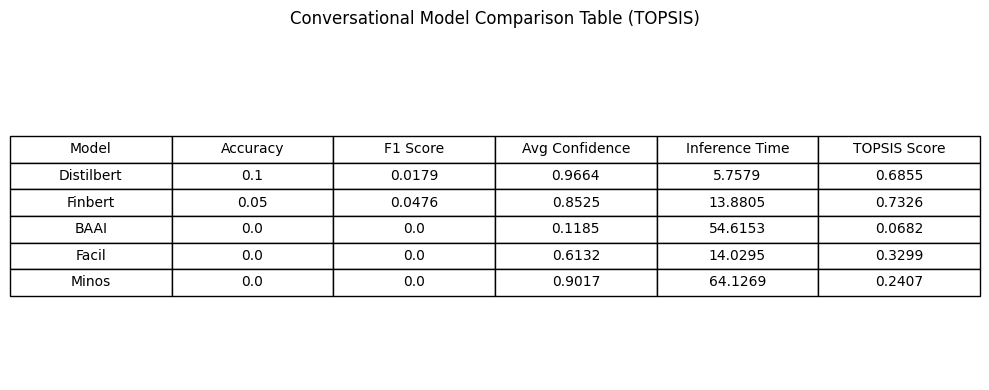

In [21]:
# Table Display
plt.figure(figsize = (10, 4))
plt.axis('off')
df_rounded = df.round(4)

table = plt.table(
    cellText = df_rounded.values,
    colLabels = df.columns,
    loc = 'center',
    cellLoc = 'center'
)

table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Conversational Model Comparison Table (TOPSIS)", pad = 20)
plt.tight_layout()

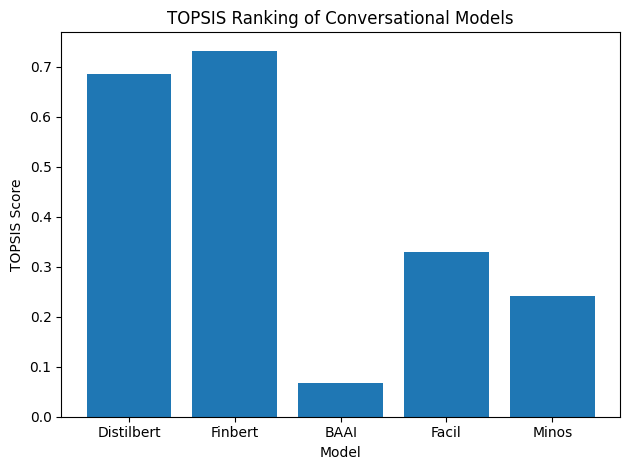

In [22]:
# Topsis Graph
plt.figure()
plt.bar(df["Model"], df["TOPSIS Score"])
plt.title("TOPSIS Ranking of Conversational Models")
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.tight_layout()
plt.show()

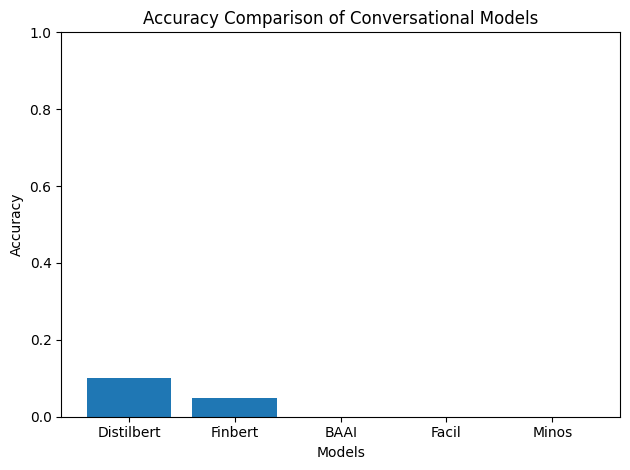

In [23]:
# Accuracy Graph
plt.figure()
plt.bar(df["Model"], df["Accuracy"])
plt.title("Accuracy Comparison of Conversational Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()